# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, f1_score
from datetime import timedelta

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        # print(image)

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
# Quang's path
df = pd.read_csv("/content/drive/My Drive/My Files/Documents/AI & Machine Learning & Deep Learning/Machine Learning/Fundamental-ML-main/Fundamental-ML-main/data/icml_face_data.csv")
# # Huân's path
# df = pd.read_csv("/content/drive/My Drive/Machine Learning/mini project/Fundamental-ML-main/data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

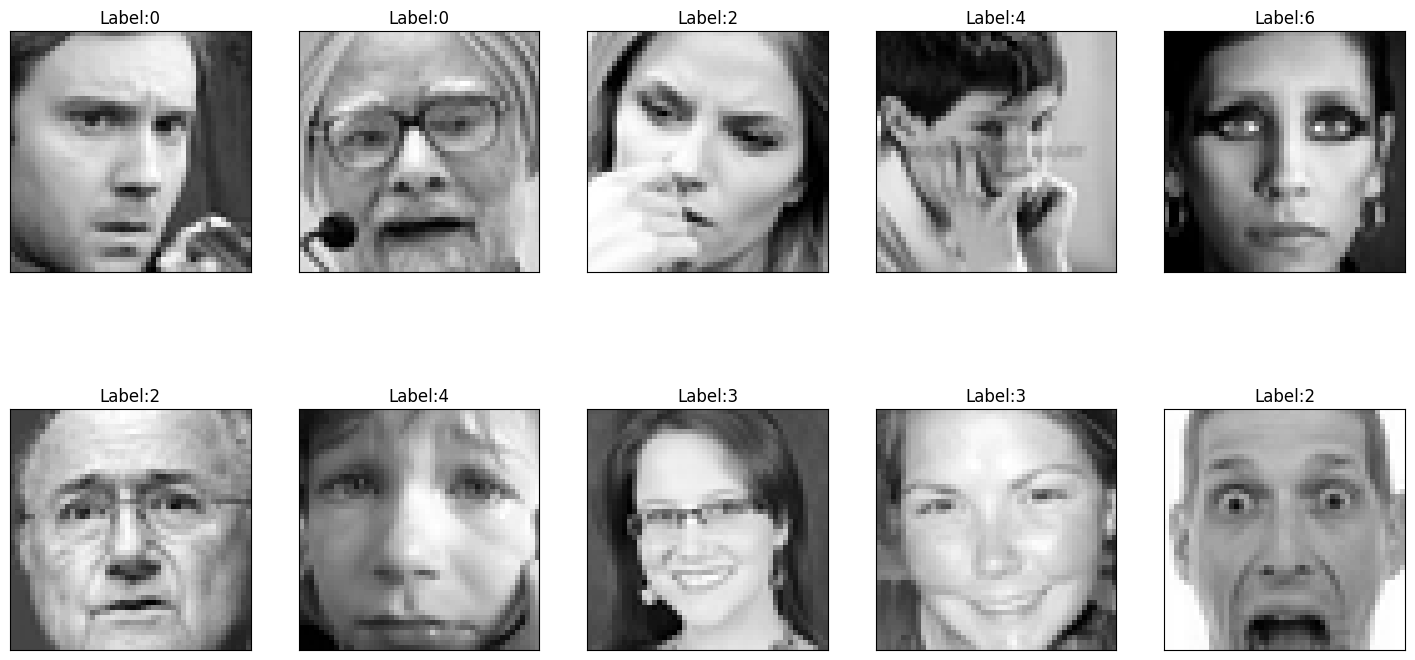

In [ ]:
## showing images here
show_img(images, labels)

## Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
dtypes: int64(1), object(1)
memory usage: 560.9+ KB


In [ ]:
df.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [ ]:
# Check missing values
df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [ ]:
print(images.shape)
# print(images[0].shape)

(35887, 48, 48)


In [ ]:
print(labels.shape)

(35887,)


## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
reshape_images = np.reshape(images, (35887, 48*48))

In [ ]:
print(reshape_images.shape)

(35887, 2304)


In [ ]:
# Scale data
scaler = MinMaxScaler()

In [ ]:
scaler.fit(reshape_images)

MinMaxScaler()

In [ ]:
scaled_data = scaler.transform(reshape_images)

In [ ]:
pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape

In [ ]:
pca.fit(scaled_data) # modify images' array to the appropriate shape

PCA(n_components=2)

In [ ]:
# transform for visualizing here
images_pca=pca.transform(scaled_data) ## modify images' array to the appropriate shape
images_pca.shape

(35887, 2)

In [ ]:
# Check the values of eigen vectors
# prodeced by principal components
pca.components_

array([[-0.02427714, -0.02406147, -0.02399324, ..., -0.02333263,
        -0.02339523, -0.02336868],
       [ 0.03270253,  0.03383058,  0.03437297, ...,  0.01116317,
         0.01205157,  0.01238002]])

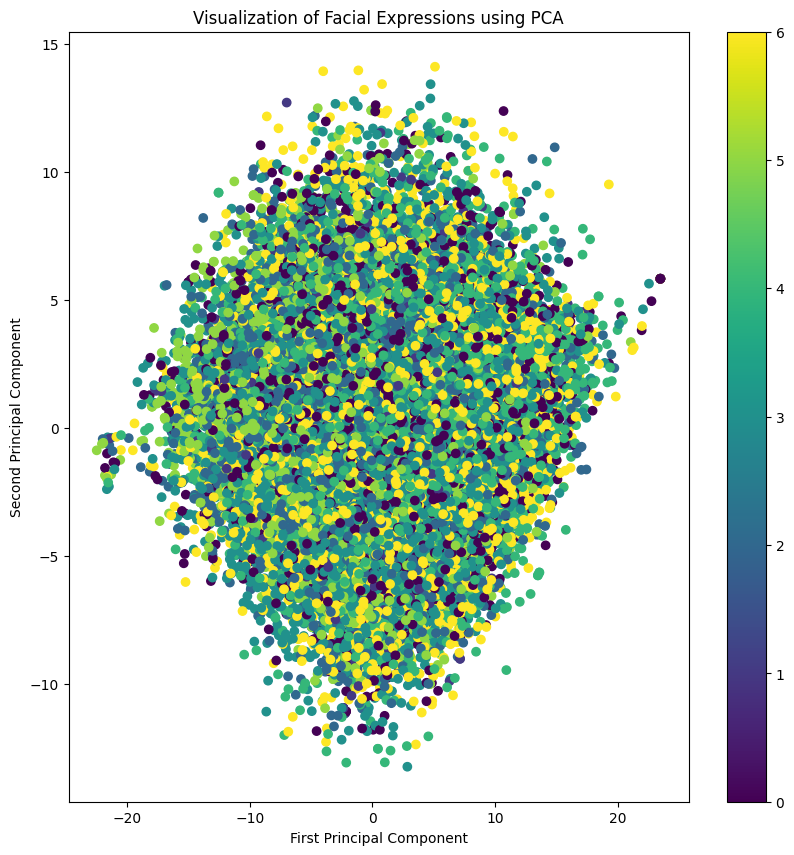

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.title('Visualization of Facial Expressions using PCA')
plt.show()

_____________________________________________________________

- We can't visualize the data projected onto two principal components because it doesn't classify to each group good enough.

_____________________________________________________________

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [ ]:
# determine the optimal number of PCs here
pca.explained_variance_

array([40.98614679, 13.88906504])

In [ ]:
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

[0.2892651 0.0980239]


In [ ]:
pca_1 = PCA().fit(scaled_data)

In [ ]:
# Using numpy for caculating n_components

explained_var_ratio = pca_1.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

optimal_n_components = np.argmax(cumulative_var_ratio >= 0.95) + 1

print(f"Number of principle n_components: {optimal_n_components}")

Number of principle n_components: 255


In [ ]:
# Using thoery for caculating n_components

explained_var_sum = pca_1.explained_variance_.sum()
for k in range(1, 2305):
    explained_var_sum_k = pca_1.explained_variance_[:k].sum()
    ratio = explained_var_sum_k/ explained_var_sum
    if ratio >= 0.95:
        print(f"Number of principle n_components: {k}")
        break

Number of principle n_components: 255


Explain:
_____________________________________________________________

- One way to determine K is based on the amount of information to be retained. As mentioned, PCA is also known as the method of maximizing the total retained variance. So, we can consider the total retained variances as the amount of retained information. The larger the variance, the higher the data dispersion, indicating a larger amount of information.

- Recall that in any coordinate system, the total variance of the data is the same and equals the sum of the eigenvalues sum(λ_i)(i in [1,2304]). Furthermore, PCA helps retain the amount of information (the total variances) as: sum(λ_j)(i in [1,k] with k is number of feature after reducing). Therefore, we can consider the expression:

        ratio = (sum(λ_j) / sum(λ_i))

- We expect to retain 95% of the data, so we need to choose k as the smallest integer such that
(ratio => 0.95).

- When the data is distributed around a subspace, the largest variance values corresponding to the first λ_i are much larger than the remaining variances. In that case, we can choose a fairly small k to achieve
( ratio >= 0.95 ).

_____________________________________________________________

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

_____________________________________________________________

_____________________________________________________________

## Split data

In [ ]:
## splitting data into train/val/test subsets here

RANDOM_STATE = 42
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.2

trainX, testX ,trainY, testY = train_test_split(scaled_data, labels, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

X_train, valX, Y_train, valY = train_test_split(trainX, trainY, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

In [ ]:
# Save
original_X_train = X_train.copy()
original_valX = valX.copy()
original_testX = testX.copy()
original_Y_train = Y_train.copy()
original_valY = valY.copy()
original_testY = testY.copy()

In [ ]:
print(original_X_train.shape)
print(original_valX.shape)
print(original_testX.shape)
print(Y_train.shape)
print(valY.shape)
print(testY.shape)

(22967, 2304)
(5742, 2304)
(7178, 2304)
(22967,)
(5742,)
(7178,)


# Original data:
_____________________________________________________________

## Feature Engineering (using CNN model to extract features)

In [ ]:
def CNN():
    CNN_model = Sequential()

    CNN_model.add(Conv2D(filters = 96, input_shape = (48, 48, 1), kernel_size = (3, 3), strides = (1, 1), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))

    CNN_model.add(Conv2D(filters = 256,  kernel_size = (3, 3), strides = (1, 1), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))

    CNN_model.add(Flatten())
    CNN_model.add(Dense(512))
    CNN_model.add(Activation('relu'))

    CNN_model.add(Dense(256))
    CNN_model.add(Activation('relu'))

    # CNN_model.add(Dense(7, activation = 'softmax'))

    return CNN_model

In [ ]:
# reshape, again

# X_train = X_train / 255.0

X_train = X_train.reshape(-1, 48, 48, 1)
valX = valX.reshape(-1, 48, 48, 1)
testX = testX.reshape(-1, 48, 48, 1)

In [ ]:
# Create the feature extractor

feature_extractor = CNN()

In [ ]:
# Extract features from reshape_images

train_features = feature_extractor.predict(X_train)
val_features = feature_extractor.predict(valX)
test_features = feature_extractor.predict(testX)

225/225 [==============================] - 34s 150ms/step


In [ ]:
print(train_features.shape)
print(train_features.shape[1])
print(val_features.shape)
print(test_features.shape)
print(Y_train.shape)
print(valY.shape)
print(testY.shape)

(22967, 256)
256
(5742, 256)
(7178, 256)
(22967,)
(5742,)
(7178,)


## SVM without gridsearch

In [ ]:
# # K-Fold cross validation

# model = SVC()
# kf = KFold(n_splits = 3, random_state=RANDOM_STATE, shuffle=True)
# vc_results = cross_val_score(model, train_features, Y_train, cv=kf)
# print("Cross-validation scores: ", vc_results)
# print("Average cross-validation score: ", vc_results.mean())

# # Draw boxplot
# plt.boxplot(vc_results, labels=["SVM"])
# plt.show()

In [ ]:
# Train model from train set

svm_model_without_grid = make_pipeline(MinMaxScaler(), SVC())
svm_model_without_grid.fit(train_features, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC())])

In [ ]:
# Validate the model

val_predictions = svm_model_without_grid.predict(val_features)
val_accuracy = accuracy_score(valY, val_predictions)
print(f'Accuracy on validation set: {val_accuracy}')

Accuracy on validation set: 0.38697318007662834


In [ ]:
# Final test the model

test_predictions = svm_model_without_grid.predict(test_features)
test_accuracy = accuracy_score(testY, test_predictions)
print(f'Final accuracy on test set: {test_accuracy}')

Final accuracy on test set: 0.37656728893842295


In [ ]:
print(classification_report(testY, svm_model_without_grid.predict(test_features)))

              precision    recall  f1-score   support

           0       0.30      0.08      0.13       985
           1       0.00      0.00      0.00       102
           2       0.30      0.11      0.16      1043
           3       0.39      0.72      0.50      1765
           4       0.32      0.36      0.34      1210
           5       0.52      0.39      0.45       795
           6       0.38      0.38      0.38      1278

    accuracy                           0.38      7178
   macro avg       0.32      0.29      0.28      7178
weighted avg       0.36      0.38      0.34      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM with gridsearch

In [ ]:
# # Defining the parameters grid for GridSearchCV
# parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000],
#             'gamma':["scale", 0.001, 0.005, 0.1],
#             'kernel':['rbf', 'poly']
#}

# # Creating a scorer
# scorer = make_scorer(recall_score, average='macro')  # choose 'None',  'macro', 'weighted', 'micro'

# ## Note:
# # 'macro': tất cả các lớp đều quan trọng như nhau và muốn mô hình có hiệu suất tốt trên tất cả các lớp. Điều này đảm bảo mô hình không tập trung quá nhiều vào các lớp có nhiều mẫu hơn.
# # 'micro': mô hình có hiệu suất tốt nhất có thể trên tổng thể tất cả các mẫu. Điều này đảm bảo mô hình sẽ tập trung vào việc phân loại chính xác những lớp có nhiều mẫu hơn.
# # 'weighted': sự cân đối giữa số lượng mẫu của các lớp và hiệu suất của mô hình trên từng lớp. Điều này sẽ đảm bảo rằng mô hình sẽ tập trung vào việc phân loại chính xác những lớp có nhiều mẫu hơn nhưng vẫn cố gắng phân loại chính xác các lớp khác.

# # Creating a model using GridSearchCV with the parameters grid
# svm_model = make_pipeline(MinMaxScaler(), GridSearchCV(SVC(), parameters, scoring=scorer, cv=3, verbose=1))

In [ ]:
## Defining the parameters grid for RandomizedSearchCV
# param_distributions = {
#     'C': np.logspace(-3, 3, 7),
#     'gamma': ["scale", "auto"] + list(np.logspace(-3, 2, 6)),
#     'kernel':['rbf', 'poly']
# }

# # Creating a scorer
# scorer = make_scorer(recall_score, average='macro')

# # Creating a model using RandomizedSearchCV with the parameters grid

# svm_model = make_pipeline(MinMaxScaler(), RandomizedSearchCV(SVC(), param_distributions=param_distributions, n_iter=3, scoring=scorer, cv=3, verbose=1, random_state=RANDOM_STATE))

- Because when we use GridSearchCV, it may take a lot of times (over 7 hours with n_iter = 10; default kernel or leave it to parameters, with default CPU in colab) and RandomizedSearchCV (over 3 hours with n_iter=10; default kernel or leave it to param_distributions, with default CPU in colab) but can not done the task. So we will use Bayesian Optimization (BayesSearchCV, with n_iter=3, default kernel) instead.

- About 2 SearchCV above, please read it in README.md

In [ ]:
param_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    # 'degree': (1, 8),  # integer valued parameter
    # 'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
}

# Creating a scorer
svm_scorer = make_scorer(accuracy_score)

# Use StratifiedKFold để cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Creating a model using Bayesian Optimization with the parameters grid

svm_model = make_pipeline(MinMaxScaler(), BayesSearchCV(SVC(), param_space, n_iter=3, scoring=svm_scorer, cv=cv, verbose=1, random_state=RANDOM_STATE))

In [ ]:
svm_model.fit(train_features, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('bayessearchcv',
                 BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                               estimator=SVC(), n_iter=3, random_state=42,
                               scoring=make_scorer(accuracy_score),
                               search_spaces={'C': (1e-06, 1000000.0,
                                                    'log-uniform'),
                                              'gamma': (1e-06, 10.0,
                                                        'log-uniform')},
                               verbose=1))])

In [ ]:
# Get best hyperparameters

best_params = svm_model.named_steps['bayessearchcv'].best_params_
print("Best Parameters:", best_params)

Best Parameters: OrderedDict([('C', 11185.625288472094), ('gamma', 1.5247791391944723)])


In [ ]:
from collections import OrderedDict

In [ ]:
best_params = OrderedDict([('C', 11185.625288472094), ('gamma', 1.5247791391944723)])

In [ ]:
# Training the model using the best param
best_svm_model = make_pipeline(MinMaxScaler(), SVC(**best_params, kernel='rbf'))
best_svm_model.fit(train_features, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=11185.625288472094, gamma=1.5247791391944723))])

In [ ]:
# Validate the model

val_predictions_best_svm_model = best_svm_model.predict(val_features)
val_accuracy_best_svm_model = accuracy_score(valY, val_predictions_best_svm_model)
print(f'Accuracy on validation set: {val_accuracy_best_svm_model}')

Accuracy on validation set: 0.45750609543712994


In [ ]:
# Final test the model

test_predictions_best_svm_model = best_svm_model.predict(test_features)
test_accuracy_best_svm_model = accuracy_score(testY, test_predictions_best_svm_model)
print(f'Final accuracy on test set: {test_accuracy_best_svm_model}')

Final accuracy on test set: 0.44176650877681806


In [ ]:
print(classification_report(testY, best_svm_model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.41      0.24      0.30       985
           1       0.97      0.31      0.47       102
           2       0.49      0.31      0.38      1043
           3       0.44      0.72      0.54      1765
           4       0.32      0.41      0.36      1210
           5       0.71      0.46      0.56       795
           6       0.47      0.34      0.40      1278

    accuracy                           0.44      7178
   macro avg       0.54      0.40      0.43      7178
weighted avg       0.47      0.44      0.43      7178



## Softmax Regression

In [ ]:
parameters = {
    # 'C': (1e-6, 1e+6, 'log-uniform'),
    # 'penalty': ['none', 'l2'],
    # 'solver': ['lbfgs', 'sag'],
    # 'multi_class': ['multinomial']

    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['none', 'l2'],
    'solver': ['lbfgs', 'sag'],
}

# Creating a scorer
log_multi_scorer = make_scorer(accuracy_score)

# Use StratifiedKFold để cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Creating a model using Bayesian Optimization with the parameters grid
log_multi_model = make_pipeline(MinMaxScaler(), GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=RANDOM_STATE), parameters, scoring=log_multi_scorer, cv=cv, verbose=1))

In [ ]:
log_multi_model.fit(train_features, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: Futur

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                              estimator=LogisticRegression(multi_class='multinomial',
                                                           random_state=42),
                              param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                                          'penalty': ['none', 'l2'],
                                          'solver': ['lbfgs', 'sag']},
                              scoring=make_scorer(accuracy_score),
                              verbose=1))])

In [ ]:
# Get best hyperparameters

best_parameters = log_multi_model.named_steps['gridsearchcv'].best_params_
print("Best Parameters:", best_parameters)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'sag'}


In [ ]:
best_parameters = {'C': 1, 'penalty': 'l2', 'solver': 'sag'}

In [ ]:
# Training the model using the best param

best_log_multi_model = make_pipeline(MinMaxScaler(), LogisticRegression(**best_parameters, multi_class='multinomial', class_weight='balanced'))
best_log_multi_model.fit(train_features, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced',
                                    multi_class='multinomial', solver='sag'))])

In [ ]:
# Validate the model

val_predictions_best_log_multi_model = best_log_multi_model.predict(val_features)
val_accuracy_best_log_multi_model = accuracy_score(valY, val_predictions_best_log_multi_model)
print(f'Accuracy on validation set: {val_accuracy_best_log_multi_model}')

Accuracy on validation set: 0.31835597352838735


In [ ]:
# Final test the model

test_predictions_best_log_multi_model = best_log_multi_model.predict(test_features)
test_accuracy_best_log_multi_model = accuracy_score(testY, test_predictions_best_log_multi_model)
print(f'Final accuracy on test set: {test_accuracy_best_log_multi_model}')

Final accuracy on test set: 0.30161604903872946


In [ ]:
print(classification_report(testY, best_log_multi_model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.24      0.19      0.21       985
           1       0.05      0.50      0.08       102
           2       0.24      0.13      0.17      1043
           3       0.49      0.41      0.45      1765
           4       0.28      0.21      0.24      1210
           5       0.34      0.51      0.41       795
           6       0.36      0.32      0.34      1278

    accuracy                           0.30      7178
   macro avg       0.28      0.32      0.27      7178
weighted avg       0.34      0.30      0.31      7178



## Random Forest

In [ ]:
param_distributions = {
    'n_estimators': (10, 100),
    'max_depth': (1, 32),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (1, train_features.shape[1] + 1)
}

# Creating a scorer
random_forest_scorer = make_scorer(accuracy_score)

# Use StratifiedKFold để cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Creating a model using Bayesian Optimization with the parameters grid
random_forest_model = make_pipeline(MinMaxScaler(), BayesSearchCV(RandomForestClassifier(), search_spaces=param_distributions, n_iter=3, scoring=random_forest_scorer, cv=cv, verbose=1, random_state=RANDOM_STATE))

In [ ]:
random_forest_model.fit(train_features, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('bayessearchcv',
                 BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                               estimator=RandomForestClassifier(), n_iter=3,
                               random_state=42,
                               scoring=make_scorer(accuracy_score),
                               search_spaces={'max_depth': (1, 32),
                                              'max_features': (1, 257),
                                              'min_samples_leaf': (1, 10),
                                              'min_samples_split': (2, 10),
                                              'n_estimators': (10, 100)},
                               verbose=1))])

In [ ]:
# Get best hyperparameters

best_parameters = random_forest_model.named_steps['bayessearchcv'].best_params_
print("Best Parameters:", best_parameters)

Best Parameters: OrderedDict([('max_depth', 27), ('max_features', 227), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 88)])


In [ ]:
best_parameters = OrderedDict([('max_depth', 27), ('max_features', 227), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 88)])

In [ ]:
# Training the model using the best param

best_random_forest_model = make_pipeline(MinMaxScaler(), RandomForestClassifier(**best_parameters))
best_random_forest_model.fit(train_features, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=27, max_features=227,
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=88))])

In [ ]:
# Validate the model

val_predictions_best_random_forest_model = best_random_forest_model.predict(val_features)
val_accuracy_best_random_forest_model = accuracy_score(valY, val_predictions_best_random_forest_model)
print(f'Accuracy on validation set: {val_accuracy_best_random_forest_model}')

Accuracy on validation set: 0.3963775687913619


In [ ]:
# Final test the model

test_predictions_best_random_forest_model = best_random_forest_model.predict(test_features)
test_accuracy_best_random_forest_model = accuracy_score(testY, test_predictions_best_random_forest_model)
print(f'Final accuracy on test set: {test_accuracy_best_random_forest_model}')

Final accuracy on test set: 0.3884090275842853


In [ ]:
print(classification_report(testY, best_random_forest_model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.42      0.17      0.24       985
           1       1.00      0.15      0.26       102
           2       0.44      0.23      0.30      1043
           3       0.37      0.72      0.48      1765
           4       0.33      0.32      0.32      1210
           5       0.58      0.44      0.50       795
           6       0.38      0.28      0.32      1278

    accuracy                           0.39      7178
   macro avg       0.50      0.33      0.35      7178
weighted avg       0.41      0.39      0.37      7178



## Deep Learning Model (using MLP)

In [ ]:
# Define parameters for search
params = {
    'activation' : Categorical(['tanh', 'relu']),
    'solver' : Categorical(['sgd', 'adam']),
    'alpha' : Real(1e-6, 1e-2, prior='log-uniform'),
    'learning_rate' : Categorical(['constant', 'adaptive']),
    'max_iter' : Integer(100, 500)

    # 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    # 'activation': ['tanh', 'relu'],
    # 'solver': ['sgd', 'adam'],
    # 'alpha': [0.0001, 0.05],
    # 'learning_rate': ['constant','adaptive'],
    # 'max_iter': [100, 150]
}

# Create a scorer
mlp_scorer = make_scorer(accuracy_score)

# Use StratifiedKFold để cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Create a model using Bayesian Optimization with the parameters grid
mlp_model = make_pipeline(MinMaxScaler(), BayesSearchCV(MLPClassifier(random_state=RANDOM_STATE), search_spaces=params, n_iter=3, scoring=mlp_scorer, cv=cv, verbose=1, random_state=RANDOM_STATE))

In [ ]:
mlp_model.fit(train_features, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (226) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (226) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (226) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (480) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (273) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (273) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (273) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (226) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('bayessearchcv',
                 BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                               estimator=MLPClassifier(random_state=42),
                               n_iter=3, random_state=42,
                               scoring=make_scorer(accuracy_score),
                               search_spaces={'activation': Categorical(categories=('tanh', 'relu'), prior=None),
                                              'alpha': Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
                                              'learning_rate': Categorical(categories=('constant', 'adaptive'), prior=None),
                                              'max_iter': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                                              'solver': Categorical(categories=('sgd', 'adam'), prior=None)},
                               verbose=1))])

In [ ]:
# Get best hyperparameters

best_parameters = mlp_model.named_steps['bayessearchcv'].best_params_
print("Best Parameters:", best_parameters)

Best Parameters: OrderedDict([('activation', 'tanh'), ('alpha', 0.0008145222883402799), ('learning_rate', 'adaptive'), ('max_iter', 226), ('solver', 'adam')])


In [ ]:
best_parameters = OrderedDict([('activation', 'tanh'), ('alpha', 0.0008145222883402799), ('learning_rate', 'adaptive'), ('max_iter', 226), ('solver', 'adam')])

In [ ]:
# Training the model using the best param

best_mlp_model = make_pipeline(MinMaxScaler(), MLPClassifier(**best_parameters))
best_mlp_model.fit(train_features, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (226) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.0008145222883402799,
                               learning_rate='adaptive', max_iter=226))])

In [ ]:
# Validate the model

val_predictions_best_mlp_model = best_mlp_model.predict(val_features)
val_accuracy_best_mlp_model = accuracy_score(valY, val_predictions_best_mlp_model)
print(f'Accuracy on validation set: {val_accuracy_best_mlp_model}')

Accuracy on validation set: 0.3894113549285963


In [ ]:
# Final test the model

test_predictions_best_mlp_model = best_mlp_model.predict(test_features)
test_accuracy_best_mlp_model = accuracy_score(testY, test_predictions_best_mlp_model)
print(f'Final accuracy on test set: {test_accuracy_best_mlp_model}')

Final accuracy on test set: 0.37308442463081637


In [ ]:
print(classification_report(testY, best_mlp_model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.26      0.32      0.28       985
           1       0.27      0.03      0.05       102
           2       0.26      0.18      0.21      1043
           3       0.44      0.66      0.52      1765
           4       0.31      0.20      0.25      1210
           5       0.48      0.45      0.46       795
           6       0.40      0.33      0.36      1278

    accuracy                           0.37      7178
   macro avg       0.34      0.31      0.31      7178
weighted avg       0.36      0.37      0.36      7178



# Transformed data:
_____________________________________________________________

In [ ]:
optimal_n_components = 255 # in previous question
pca = PCA(n_components= optimal_n_components)
pca.fit(reshape_images)
images_pca_optimals = pca.transform(reshape_images) ## modify images' array to the appropriate shape

## Split data

In [ ]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.2

combineX_pca, testX_pca ,combineY_pca, testY_pca = train_test_split(images_pca_optimals, labels, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

trainX_pca, valX_pca, train_Y_pca, valY_pca = train_test_split(combineX_pca, combineY_pca, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

In [ ]:
scorer = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
print(trainX_pca.shape)
print(valX_pca.shape)
print(testX_pca.shape)
print(train_Y_pca.shape)
print(valY_pca.shape)
print(testY_pca.shape)

(22967, 255)
(5742, 255)
(7178, 255)
(22967,)
(5742,)
(7178,)


## SVM model with pca


In [ ]:
# Defining the parameters grid for GridSearchCV
parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000],
            'gamma':["scale", 0.001, 0.005, 0.1]}

#gridsearch_svm = make_pipeline(MinMaxScaler(), GridSearchCV(SVC(), parameters, scoring=scorer, cv=3, verbose=1))
gridsearch_svm = make_pipeline(MinMaxScaler(), BayesSearchCV(SVC(), parameters, n_iter=3, scoring=scorer, cv=cv, verbose=1, random_state=RANDOM_STATE))

In [ ]:
gridsearch_svm.fit(trainX_pca,train_Y_pca)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('bayessearchcv',
                 BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                               estimator=SVC(), n_iter=3, random_state=42,
                               scoring=make_scorer(accuracy_score),
                               search_spaces={'C': [0.01, 0.1, 1, 10, 100,
                                                    1000],
                                              'gamma': ['scale', 0.001, 0.005,
                                                        0.1]},
                               verbose=1))])

In [ ]:
gridsearch_svm[1].best_params_

OrderedDict([('C', 1000), ('gamma', 0.1)])

In [ ]:
svm_model_pca = make_pipeline(MinMaxScaler(), SVC(C = 1000,gamma = 0.1))
svm_model_pca.fit(trainX_pca,train_Y_pca)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=1000, gamma=0.1))])

In [ ]:
print(classification_report(testY_pca, svm_model_pca.predict(testX_pca)))

              precision    recall  f1-score   support

           0       0.29      0.34      0.32       985
           1       0.53      0.37      0.44       102
           2       0.35      0.35      0.35      1043
           3       0.55      0.61      0.58      1765
           4       0.34      0.32      0.33      1210
           5       0.62      0.55      0.59       795
           6       0.40      0.35      0.37      1278

    accuracy                           0.43      7178
   macro avg       0.44      0.41      0.42      7178
weighted avg       0.43      0.43      0.43      7178



In [ ]:
pred_svm_pca = svm_model_pca.predict(testX_pca)
accuracy_svm_pca = accuracy_score(testY_pca, pred_svm_pca)

In [ ]:
print(f'Main metric for SVM with pca: {accuracy_svm_pca}')

Main metric for SVM with pca: 0.4313179158539983


## Softmax model with pca


In [ ]:
# Defining the parameters grid for GridSearchCV
parameters = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'penalty': ['none', 'l2'],
    'solver': ['lbfgs', 'sag'],
}

gridsearch_softmax = make_pipeline(MinMaxScaler(), GridSearchCV(LogisticRegression(multi_class='multinomial'),parameters, scoring=scorer, cv=cv))


In [ ]:
gridsearch_softmax.fit(trainX_pca,train_Y_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: Futur

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                              estimator=LogisticRegression(multi_class='multinomial'),
                              param_grid={'C': (1e-06, 1000000.0,
                                                'log-uniform'),
                                          'penalty': ['none', 'l2'],
                                          'solver': ['lbfgs', 'sag']},
                              scoring=make_scorer(accuracy_score)))])

In [ ]:
gridsearch_softmax[1].best_params_

{'C': 1000000.0, 'penalty': 'l2', 'solver': 'sag'}

In [ ]:
softmax_model_pca = make_pipeline(MinMaxScaler(), LogisticRegression(multi_class='multinomial',C = 1000000.0, penalty = 'l2', solver = 'sag'))
softmax_model_pca.fit(trainX_pca,train_Y_pca)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1000000.0, multi_class='multinomial',
                                    solver='sag'))])

In [ ]:
print(classification_report(testY_pca, softmax_model_pca.predict(testX_pca)))

              precision    recall  f1-score   support

           0       0.28      0.16      0.20       985
           1       0.30      0.06      0.10       102
           2       0.26      0.15      0.19      1043
           3       0.43      0.66      0.52      1765
           4       0.28      0.28      0.28      1210
           5       0.47      0.45      0.46       795
           6       0.35      0.35      0.35      1278

    accuracy                           0.37      7178
   macro avg       0.34      0.30      0.30      7178
weighted avg       0.35      0.37      0.35      7178



In [ ]:
pred_softmax_pca = softmax_model_pca.predict(testX_pca)
accuracy_softmax_pca = accuracy_score(testY_pca, pred_softmax_pca)

In [ ]:
print(f'Main metric for softmax with pca: {accuracy_softmax_pca}')

Main metric for softmax with pca: 0.36695458344942883


## Random Forest with pca

In [ ]:
forest_params = {
    'n_estimators': (10, 100),
    'max_depth': (1, 32),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (1,trainX_pca.shape[1] + 1)
}

gridsearch = GridSearchCV(RandomForestClassifier(), forest_params, cv = cv, scoring=scorer)

gridsearch_forest = make_pipeline(MinMaxScaler(), gridsearch)

In [ ]:
gridsearch_forest.fit(trainX_pca,train_Y_pca)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                              estimator=RandomForestClassifier(),
                              param_grid={'max_depth': (1, 32),
                                          'max_features': (1, 256),
                                          'min_samples_leaf': (1, 10),
                                          'min_samples_split': (2, 10),
                                          'n_estimators': (10, 100)},
                              scoring=make_scorer(accuracy_score)))])

In [ ]:
gridsearch_forest[1].best_params_

{'max_depth': 32,
 'max_features': 256,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [ ]:
forest_model_pca = make_pipeline(MinMaxScaler(), RandomForestClassifier(max_depth= 32,max_features = 256, min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100))
forest_model_pca.fit(trainX_pca,train_Y_pca)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=32, max_features=256,
                                        min_samples_split=10))])

In [ ]:
print(classification_report(testY_pca, forest_model_pca.predict(testX_pca)))

              precision    recall  f1-score   support

           0       0.50      0.15      0.23       985
           1       1.00      0.19      0.31       102
           2       0.44      0.23      0.30      1043
           3       0.39      0.73      0.51      1765
           4       0.32      0.31      0.31      1210
           5       0.57      0.51      0.54       795
           6       0.36      0.30      0.33      1278

    accuracy                           0.40      7178
   macro avg       0.51      0.35      0.36      7178
weighted avg       0.42      0.40      0.38      7178



In [ ]:
pred_forest_pca = forest_model_pca.predict(testX_pca)
accuracy_forest_pca = accuracy_score(testY_pca, pred_forest_pca)

In [ ]:
print(f'Main metric for forest random with pca: {accuracy_forest_pca}')

Main metric for forest random with pca: 0.3998328225132349


## MLP with pca

In [ ]:
# Define parameters for search
params = {
    'activation' : Categorical(['tanh', 'relu']),
    'solver' : Categorical(['sgd', 'adam']),
    'alpha' : Real(1e-6, 1e-2, prior='log-uniform'),
    'learning_rate' : Categorical(['constant', 'adaptive']),
    'max_iter' : Integer(100, 500)
}


# Create a model using Bayesian Optimization with the parameters grid
gridsearch_mlp_pca = make_pipeline(MinMaxScaler(), BayesSearchCV(MLPClassifier(random_state=RANDOM_STATE), search_spaces=params, n_iter=3, scoring=scorer, cv=cv, verbose=1, random_state=RANDOM_STATE))

In [ ]:
gridsearch_mlp_pca.fit(trainX_pca,train_Y_pca)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (273) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (273) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (273) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (480) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('bayessearchcv',
                 BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                               estimator=MLPClassifier(random_state=42),
                               n_iter=3, random_state=42,
                               scoring=make_scorer(accuracy_score),
                               search_spaces={'activation': Categorical(categories=('tanh', 'relu'), prior=None),
                                              'alpha': Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
                                              'learning_rate': Categorical(categories=('constant', 'adaptive'), prior=None),
                                              'max_iter': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                                              'solver': Categorical(categories=('sgd', 'adam'), prior=None)},
                               verbose=1))])

In [ ]:
gridsearch_mlp_pca[1].best_params_

OrderedDict([('activation', 'relu'),
             ('alpha', 0.0034139810765573975),
             ('learning_rate', 'constant'),
             ('max_iter', 480),
             ('solver', 'adam')])

In [ ]:
mlp_model_pca = make_pipeline(MinMaxScaler(), MLPClassifier(activation= 'relu',alpha= 0.0034139810765573975,learning_rate= 'constant',max_iter= 480,solver='adam'))
mlp_model_pca.fit(trainX_pca,train_Y_pca)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpclassifier',
                 MLPClassifier(alpha=0.0034139810765573975, max_iter=480))])

In [ ]:
print(classification_report(testY_pca, mlp_model_pca.predict(testX_pca)))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       985
           1       0.29      0.10      0.15       102
           2       0.28      0.22      0.25      1043
           3       0.46      0.67      0.54      1765
           4       0.27      0.43      0.33      1210
           5       0.64      0.36      0.46       795
           6       0.41      0.23      0.30      1278

    accuracy                           0.38      7178
   macro avg       0.38      0.31      0.32      7178
weighted avg       0.39      0.38      0.36      7178



In [ ]:
pred_mlp_pca = mlp_model_pca.predict(testX_pca)
accuracy_mlp_pca = accuracy_score(testY_pca, pred_mlp_pca)

In [ ]:
print(f'Main metric for MLP with pca: {accuracy_mlp_pca}')

Main metric for MLP with pca: 0.3779604346614656


# 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
# Evaluate Models

def evaluate_model(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    return accuracy, precision, recall, f1

## First Evaluation: CNN Features

In [ ]:
# Original data

svm_cnn_metrics = evaluate_model(testY, test_predictions_best_svm_model)
softmax_cnn_metrics = evaluate_model(testY, test_predictions_best_log_multi_model)
random_forest_cnn_metrics = evaluate_model(testY, test_predictions_best_random_forest_model)
mlp_cnn_metrics = evaluate_model(testY, test_predictions_best_mlp_model)

print(f'SVM CNN Metrics: \nAccuracy={svm_cnn_metrics[0]}, \nPrecision={svm_cnn_metrics[1]}, \nRecall={svm_cnn_metrics[2]}, \nF1-Score={svm_cnn_metrics[3]}')
print(f'\nSoftmax CNN Metrics: \nAccuracy={softmax_cnn_metrics[0]}, \nPrecision={softmax_cnn_metrics[1]}, \nRecall={softmax_cnn_metrics[2]}, \nF1-Score={softmax_cnn_metrics[3]}')
print(f'\nRandom Forest CNN Metrics: \nAccuracy={random_forest_cnn_metrics[0]}, \nPrecision={random_forest_cnn_metrics[1]}, \nRecall={random_forest_cnn_metrics[2]}, \nF1-Score={random_forest_cnn_metrics[3]}')
print(f'\nMLP Metrics: \nAccuracy={mlp_cnn_metrics[0]}, \nPrecision={mlp_cnn_metrics[1]}, \nRecall={mlp_cnn_metrics[2]}, \nF1-Score={mlp_cnn_metrics[3]}')

SVM CNN Metrics: 
Accuracy=0.44176650877681806, 
Precision=0.5446096676202015, 
Recall=0.40051694383490327, 
F1-Score=0.4315117005676163

Softmax CNN Metrics: 
Accuracy=0.30161604903872946, 
Precision=0.2839383724241465, 
Recall=0.32377259922009116, 
F1-Score=0.2706918608805138

Random Forest CNN Metrics: 
Accuracy=0.3884090275842853, 
Precision=0.5004331659491916, 
Recall=0.3294807919648838, 
F1-Score=0.3471673677637571

MLP Metrics: 
Accuracy=0.37308442463081637, 
Precision=0.3448028378377482, 
Recall=0.308150631828744, 
F1-Score=0.3054059511867827


After training and evaluating the SVM, Softmax Regression, Random Forest, and MLP models on the validation dataset, we obtained the following results:

| Model               | Accuracy | Precision | Recall  | F1-score |
|---------------------|----------|-----------|---------|----------|
| SVM CNN             | 0.44     | 0.54      | 0.40    | 0.43     |
| Softmax CNN         | 0.30     | 0.28      | 0.32    | 0.27     |
| Random Forest CNN   | 0.38     | 0.50      | 0.32    | 0.35     |
| MLP CNN             | 0.37     | 0.34      | 0.31    | 0.31     |

Based on these evaluation metrics, the SVM model performed the best, achieving the highest accuracy, precision, recall, and F1-score. This suggests that SVM is better suited for this data and the features extracted from the CNN.

Therefore, the SVM model is the best choice for this emotion classification task.

## Second Evaluation: PCA Features

In [ ]:
# Transform data

svm_pca_metrics = evaluate_model(testY_pca, pred_svm_pca)
softmax_pca_metrics = evaluate_model(testY_pca, pred_softmax_pca)
random_forest_pca_metrics = evaluate_model(testY_pca, pred_forest_pca)
mlp_pca_metrics = evaluate_model(testY_pca, pred_mlp_pca)

print(f'SVM PCA Metrics: \nAccuracy={svm_pca_metrics[0]}, \nPrecision={svm_pca_metrics[1]}, \nRecall={svm_pca_metrics[2]}, \nF1-Score={svm_pca_metrics[3]}')
print(f'\nSoftmax PCA Metrics: \nAccuracy={softmax_pca_metrics[0]}, \nPrecision={softmax_pca_metrics[1]}, \nRecall={softmax_pca_metrics[2]}, \nF1-Score={softmax_pca_metrics[3]}')
print(f'\nRandom Forest PCA Metrics: \nAccuracy={random_forest_pca_metrics[0]}, \nPrecision={random_forest_pca_metrics[1]}, \nRecall={random_forest_pca_metrics[2]}, \nF1-Score={random_forest_pca_metrics[3]}')
print(f'\nMLP PCA Metrics: \nAccuracy={mlp_pca_metrics[0]}, \nPrecision={mlp_pca_metrics[1]}, \nRecall={mlp_pca_metrics[2]}, \nF1-Score={mlp_pca_metrics[3]}')

SVM PCA Metrics: 
Accuracy=0.4313179158539983, 
Precision=0.44155531213495974, 
Recall=0.4142600677400881, 
F1-Score=0.4248678760776397

Softmax PCA Metrics: 
Accuracy=0.36695458344942883, 
Precision=0.3378818851229922, 
Recall=0.301447255240286, 
F1-Score=0.29997549732094264

Random Forest PCA Metrics: 
Accuracy=0.3998328225132349, 
Precision=0.5114311413444815, 
Recall=0.34601526050599934, 
F1-Score=0.3620742775208917

MLP PCA Metrics: 
Accuracy=0.3779604346614656, 
Precision=0.37665183951457243, 
Recall=0.3149539779107734, 
F1-Score=0.32309293667195993


After training and evaluating the SVM, Softmax Regression, Random Forest, and MLP models on the validation dataset, we obtained the following results:

| Model               | Accuracy | Precision | Recall  | F1-score |
|---------------------|----------|-----------|---------|----------|
| SVM PCA             | 0.43     | 0.44      | 0.41    | 0.42     |
| Softmax PCA         | 0.37     | 0.34      | 0.30    | 0.30     |
| Random Forest PCA   | 0.40     | 0.51      | 0.35    | 0.36     |
| MLP PCA             | 0.38     | 0.38      | 0.31    | 0.32     |

Based on these evaluation metrics, the SVM model performed the best, achieving the highest accuracy, recall, and F1-score. This suggests that SVM is better suited for this data and the features extracted using PCA.

Therefore, the SVM model is the best choice for this emotion classification task.


## Conclusion

- SVM models perform the best for both CNN and PCA features, as indicated by the highest scores across accuracy - that's we choose for main score.
- Random Forest performs reasonably well in both scenarios, with better performance metrics in the PCA feature space.
- Softmax Regression consistently performs the worst among all models, indicating it may not be well-suited for this particular classification task regardless of the feature extraction method.
- MLP shows moderate performance, doing slightly better with PCA features than with CNN features.

- SVM perform best because:
  + Linear or Nearly Linear Data: SVC performs well if data can be effectively separated by a hyperplane (or nearly linearly separable after kernel trick).
  + Kernel Trick: By using the kernel trick, SVC can handle non-linear data more effectively than Softmax and capture complex relationships in data.
  + Optimized Margin: Optimizing the margin between classes helps SVC avoid overfitting and generalize well on new data.
  + Fewer Parameters than MLP: SVC has fewer hyperparameters to tune compared to MLP, simplifying training and optimization.

- So that The SVC model may achieve the best results in multiclass classification due to its ability to optimize the margin between classes, effectively handle non-linear data with kernel tricks, and its resilience against overfitting compared to other models like MLP.

=> Therefore, SVM is the best model among all of them.

## Visualize

In [ ]:
## visualize the confusion matrices and classification reports here

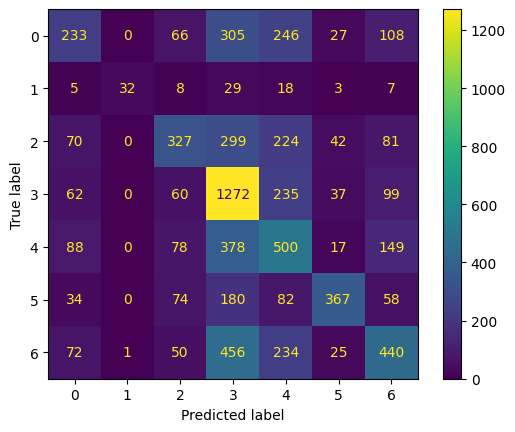

In [ ]:
cm_svm_cnn = confusion_matrix(testY, best_svm_model.predict(test_features), labels=best_svm_model.classes_)
disp_svm_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_svm_cnn, display_labels=best_svm_model.classes_)
disp_svm_cnn.plot()
plt.show()

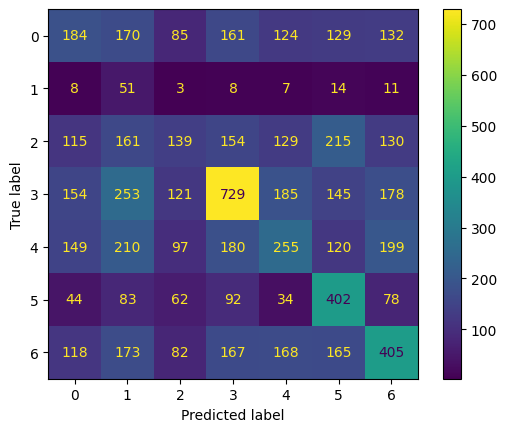

In [ ]:
cm_log_multi_cnn = confusion_matrix(testY, test_predictions_best_log_multi_model, labels=best_log_multi_model.classes_)
disp_log_multi_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_log_multi_cnn, display_labels=best_log_multi_model.classes_)
disp_log_multi_cnn.plot()
plt.show()

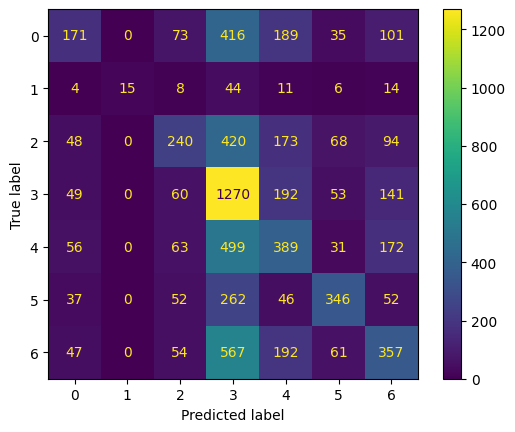

In [ ]:
cm_random_forest_cnn = confusion_matrix(testY, test_predictions_best_random_forest_model, labels=best_random_forest_model.classes_)
disp_random_forest_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest_cnn, display_labels=best_random_forest_model.classes_)
disp_random_forest_cnn.plot()
plt.show()

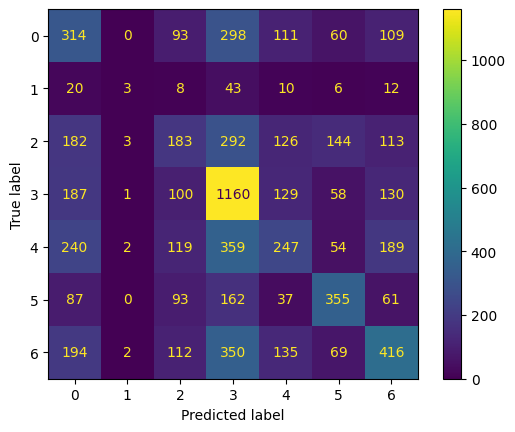

In [ ]:
cm_mlp_cnn = confusion_matrix(testY, test_predictions_best_mlp_model, labels=best_mlp_model.classes_)
disp_mlp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_mlp_cnn, display_labels=best_mlp_model.classes_)
disp_mlp_cnn.plot()
plt.show()

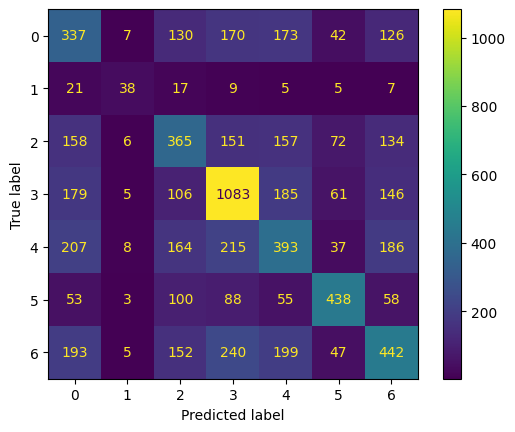

In [ ]:
cm_svm_pca = confusion_matrix(testY_pca, pred_svm_pca, labels=svm_model_pca.classes_)
disp_svm_pca = ConfusionMatrixDisplay(confusion_matrix=cm_svm_pca, display_labels=svm_model_pca.classes_)
disp_svm_pca.plot()
plt.show()

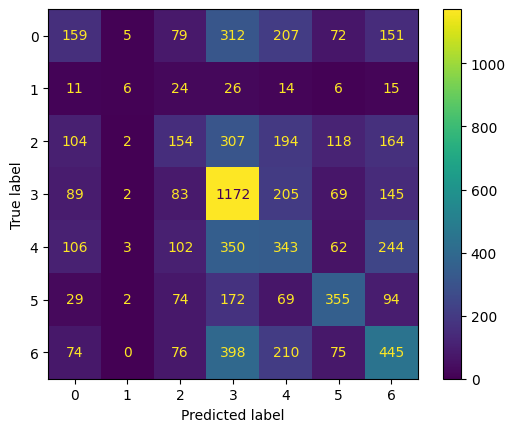

In [ ]:
cm_softmax_model_pca = confusion_matrix(testY_pca, pred_softmax_pca, labels=softmax_model_pca.classes_)
disp_softmax_model_pca = ConfusionMatrixDisplay(confusion_matrix=cm_softmax_model_pca, display_labels=softmax_model_pca.classes_)
disp_softmax_model_pca.plot()
plt.show()

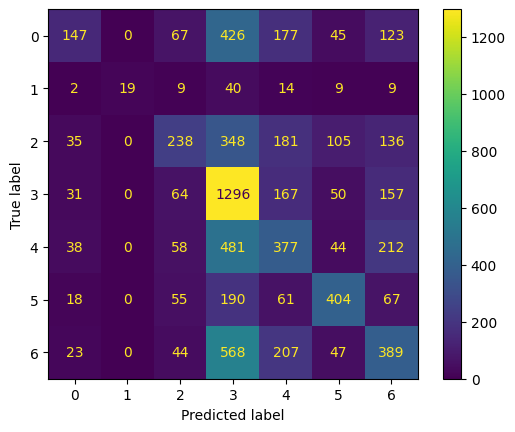

In [ ]:
cm_forest_model_pca = confusion_matrix(testY_pca, pred_forest_pca, labels=forest_model_pca.classes_)
disp_forest_model_pca = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model_pca, display_labels=forest_model_pca.classes_)
disp_forest_model_pca.plot()
plt.show()

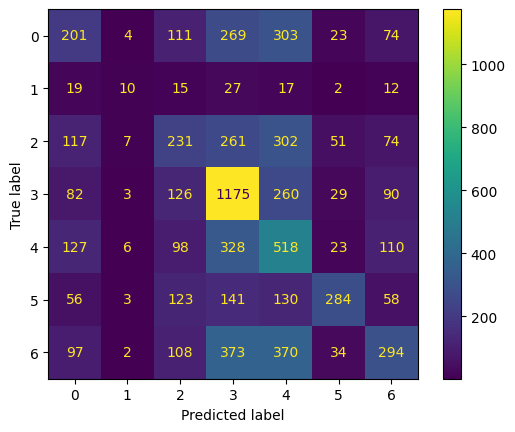

In [ ]:
cm_mlp_model_pca = confusion_matrix(testY_pca, pred_mlp_pca, labels=mlp_model_pca.classes_)
disp_mlp_model_pca = ConfusionMatrixDisplay(confusion_matrix=cm_mlp_model_pca, display_labels=mlp_model_pca.classes_)
disp_mlp_model_pca.plot()
plt.show()